In [128]:
#Import all the libraries that will be used
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#define where to find the data
path = 'data/Provisional_COVID-19.csv'

In [152]:
def calc_non_param_ci(x1, x2, alpha=0.05):
    """Calc confidence interval for 2 group median test

    Process:
      * Find all pairwise diffs
      * Sort diffs
      * Find appropriate value of k
      * Choose lower bound from diffs as: diffs[k]
      * Choose upper bound from diffs as: diffs[-k]

    Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2545906/

    :param x1: sample 1
    :param x2: sample 2
    :param alpha: significance level
    :return: (tuple) confidence interval bounds
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    n1 = x1.size
    n2 = x2.size
    cv = stats.norm.ppf(1 - alpha / 2)

    # Find pairwise differences for every datapoint in each group
    diffs = (x1[:, None] - x2).flatten()
    diffs.sort()

    # For an approximate (1-a)% confidence interval first calculate K:
    k = int(round(n1 * n2 / 2 - (cv * (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5)))

    # The Kth smallest to the Kth largest of the n x m differences
    # n1 and n2 should be > ~20
    ci_lo = diffs[k]
    ci_hi = diffs[-k]

    return ci_lo, ci_hi

def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

The following data was provided by National Center for Health Statistics (NCHS) through the Center for Disease Control and Prevention (CDC) and can be found at: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Sex-Age-and-S/9bhg-hcku .

In [99]:
df = pd.read_csv(path) #move data into a pandas dataframe
df.head() # preview the top five rows

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,All Ages,223984.0,2452180.0,228934.0,101910.0,6789.0,356777.0,NaN
1,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,Under 1 year,26.0,13879.0,131.0,4.0,16.0,169.0,NaN
2,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,0-17 years,115.0,24593.0,384.0,18.0,124.0,605.0,NaN
3,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,1-4 years,16.0,2598.0,88.0,2.0,42.0,144.0,NaN
4,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,5-14 years,39.0,4139.0,114.0,7.0,53.0,199.0,NaN


In [101]:
# remove unwanted rows to prevent duplicate accounting of entries
nolist = ['All Ages', 'Under 1 year', '1-4 years', '5-14 years', '15-24 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years' ]
for x in nolist:
    df = df[df['Age group'] != x]

In [102]:
# observe that the 'Age group' doesn't have any overlapping data
df['Age group'].unique()


array(['0-17 years', '18-29 years', '30-49 years', '50-64 years',
       '65-74 years', '75-84 years', '85 years and over'], dtype=object)

In [106]:
# see how many datasets we still have to work with
df['Age group'].value_counts()


0-17 years           163
30-49 years          163
65-74 years          163
18-29 years          163
85 years and over    163
75-84 years          163
50-64 years          163
Name: Age group, dtype: int64

In [107]:
#see if any overlap occurs in other categories...
df['State'].unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'New York City', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
       'Wyoming', 'Puerto Rico'], dtype=object)

In [110]:
#removing overlap in the 'State' category
df = df[df['State'] != 'United States']
df['Sex'].unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [109]:
#re-check the size of my datasets
df['Age group'].value_counts()


0-17 years           159
30-49 years          159
65-74 years          159
18-29 years          159
85 years and over    159
75-84 years          159
50-64 years          159
Name: Age group, dtype: int64

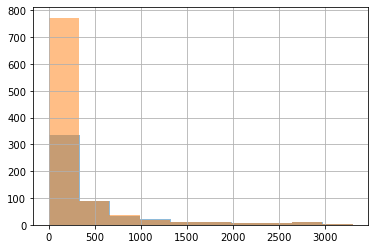

In [136]:
# comparing the distribution of data with all accounts to data only including accounts of COVID-19 deaths > 0
# this may change my question to: Of the reported COVID-19 deaths that are greater than zero, are there significant
# differnces between age groups?
df_nonzero = df[df['COVID-19 Deaths'] >= 1]
# df_nonzero['COVID-19 Deaths'].value_counts()
df_nonzero['COVID-19 Deaths'].hist(alpha = 0.5)
df['COVID-19 Deaths'].hist(alpha = 0.5)

In [137]:

df_nonzero['Age group'].value_counts()

75-84 years          104
85 years and over    103
65-74 years          102
50-64 years           98
30-49 years           83
18-29 years           28
0-17 years             2
Name: Age group, dtype: int64

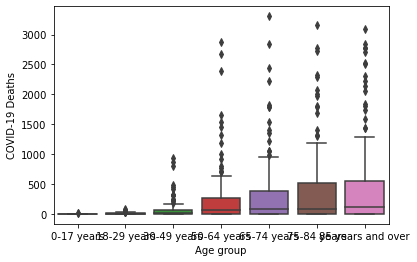

In [138]:
# observing data with '0 COVID-19 deaths reported' data included
sns.boxplot(x='Age group', y='COVID-19 Deaths', data = df)

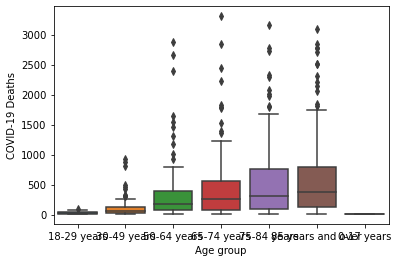

In [139]:
# observing data with COVID-19 deaths > 0
# I think that it will be of greater value to observe instances where the virus is fatally active
sns.boxplot(x='Age group', y='COVID-19 Deaths', data = df_nonzero)

In [120]:
print(len(df_nonzero['State'].unique()))

53


In [122]:
# so there is another overlap that i may have caught. There is two reportings for New York and New York City.
# I will investigate how these values are related.
df_NY = df_nonzero[df_nonzero['State'] == "New York"]
df_NYC = df_nonzero[df_nonzero['State'] == "New York City"]


In [123]:
df_NY['COVID-19 Deaths'].describe()


count      12.000000
mean      999.583333
std       832.545544
min        10.000000
25%       262.750000
50%      1029.000000
75%      1547.250000
max      2714.000000
Name: COVID-19 Deaths, dtype: float64

In [124]:
df_NYC['COVID-19 Deaths'].describe()

count      12.000000
mean     1745.416667
std      1207.462437
min        27.000000
25%       730.000000
50%      1963.500000
75%      2800.250000
max      3307.000000
Name: COVID-19 Deaths, dtype: float64

I conclude that sense the NYC deaths are much higher and the max amount for the city is greater than the max for the state, the count for the state must not include the NYC counts, and instead, it accounts for those not in NYC, but in NY state elsewhere.

None of the data grouped by 'Age group' for 'COVID-19 Deaths > 0' has a normal distribution, so a normal t-test will not due.

In [ ]:
# there are too few values for the the smaller age groups so I will combine them and compare ages 0-49 to 50+.


In [140]:
nolist = ['50-64 years', '65-74 years', '75-84 years', '85 years and over']
for x in nolist:
    df_nonzero = df_nonzero[df_nonzero['Age group'] != x]

df_0_49 = df_nonzero

df_nonzero = df[df['COVID-19 Deaths'] >= 1]

nolist = ['0-17 years', '18-29 years', '30-49 years']
for x in nolist:
    df_nonzero = df_nonzero[df_nonzero['Age group'] != x]
df_50plus = df_nonzero

DescribeResult(nobs=113, minmax=(10.0, 932.0), mean=96.070796460177, variance=25213.31637168141, skewness=3.51510548423969, kurtosis=13.470005280022523)

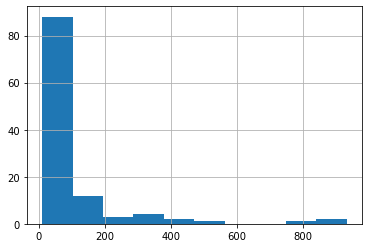

In [146]:
df_0_49['COVID-19 Deaths'].hist()
stats.describe(df_0_49['COVID-19 Deaths'])

DescribeResult(nobs=407, minmax=(10.0, 3307.0), mean=524.2383292383292, variance=446490.2460149356, skewness=2.0707850354818573, kurtosis=3.9170710792020165)

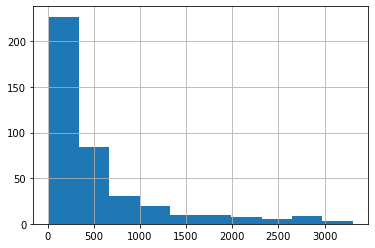

In [147]:
df_50plus['COVID-19 Deaths'].hist()
stats.describe(df_50plus['COVID-19 Deaths'])

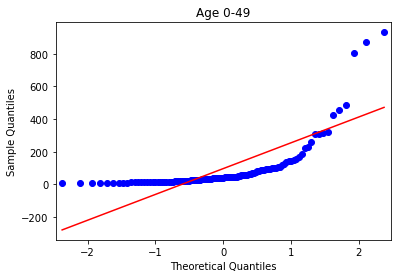

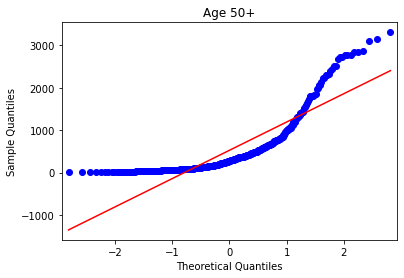

In [148]:
qqplot(df_0_49['COVID-19 Deaths'], line = 's')
plt.title("Age 0-49")
plt.show()

qqplot(df_50plus['COVID-19 Deaths'], line = 's')
plt.title('Age 50+')
plt.show()



As seen via the qqplot, the two data sets are not normally distributed, but the do have a similar distribution.

In [149]:
_, p = stats.kruskal(df_0_49['COVID-19 Deaths'], df_50plus['COVID-19 Deaths'])
p

4.9011122020891656e-26

In [150]:
p < 0.05

True

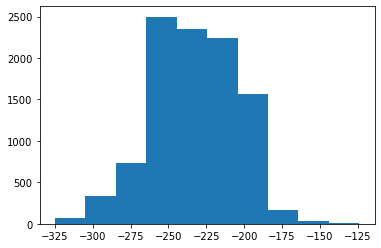

(-290.0, -186.0)

In [151]:
median_diffs = []
for i in range(10000):
    sample_1 = df_0_49['COVID-19 Deaths'].sample(frac=1.0, replace=True)
    sample_2 = df_50plus['COVID-19 Deaths'].sample(frac=1.0, replace=True)

    median_diff = sample_1.median() - sample_2.median()
    median_diffs.append(median_diff)


plt.hist(median_diffs)
plt.show()

ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)

ci_lo, ci_hi

We can see from the analysis above that when considering only non-zero death counts, there 186 to 290 more deaths reported in the '50+' age group compared to the '0-49' age group

In [153]:
calc_non_param_ci(df_0_49['COVID-19 Deaths'], df_50plus['COVID-19 Deaths'], alpha=0.05)

(-264.0, -134.0)

In [154]:
cles_ind(df_0_49['COVID-19 Deaths'], df_50plus['COVID-19 Deaths'])

0.8228783892500706

According to the common language effect size, the number of COVID-19 deaths reported from the '50+' age group would be expected to be ~82.3% larger than the COVID-19 deaths reported from the '0-49' age group when we only consider deaths reported to be >= 1.